## This colab notebook makes predictions for any desired time range using MMS data.

In [1]:
# trange = ['2022-01-09/00:00:00', '2022-01-09/23:59:00']
# trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
trange = ['2023-05-02/00:00:00', '2023-05-02/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']
# trange = ['2017-01-31/00:00:00', '2017-01-31/23:59:00']

## nightside use case
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
# trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']


## flank use case
# trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

## Installing the required packages

In [2]:
!pip install --quiet pyspedas

## Loading the Model

In [3]:
import gdown
# https://drive.google.com/file/d/12utPe2oxMuH1J3I4MucSgPqDumfBIBX4/view?usp=drive_link
# https://drive.google.com/file/d/1f2wSlhpz-t_-B30aRxtdNMXD_k378vfk/view?usp=drive_link

url = "https://drive.google.com/uc?export=download&id=12utPe2oxMuH1J3I4MucSgPqDumfBIBX4"
output = 'model_CNN.pth'
gdown.download(url, output, quiet=False)

url = "https://drive.google.com/uc?export=download&id=1f2wSlhpz-t_-B30aRxtdNMXD_k378vfk"
output = 'model_RF.pth'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=12utPe2oxMuH1J3I4MucSgPqDumfBIBX4
To: /content/model_CNN.pth
100%|██████████| 623k/623k [00:00<00:00, 98.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1f2wSlhpz-t_-B30aRxtdNMXD_k378vfk
To: /content/model_RF.pth
100%|██████████| 371k/371k [00:00<00:00, 79.8MB/s]


'model_RF.pth'

In [4]:
url = "https://drive.google.com/uc?export=download&id=1WMbfr6LHSNC65x6nauTdYFNuXtdaQsGB"
output = 'colab_utils.py'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1WMbfr6LHSNC65x6nauTdYFNuXtdaQsGB
From (redirected): https://drive.google.com/uc?export=download&id=1WMbfr6LHSNC65x6nauTdYFNuXtdaQsGB&confirm=t&uuid=c698e012-8947-48f3-854a-860665130861
To: /content/colab_utils.py
100%|██████████| 10.7k/10.7k [00:00<00:00, 17.3MB/s]


'colab_utils.py'

In [5]:
from colab_utils import FluxCNNModel

In [7]:
import torch
# Instantiate a fresh instance of multiinputmodel
loaded_CNN = FluxCNNModel()
# RFModel = rf()



# Load model state dict
loaded_CNN.load_state_dict(torch.load(f="/content/model_CNN.pth"))

print(f"Loaded model:\n{FluxCNNModel}")

Loaded model:
<class 'colab_utils.FluxCNNModel'>


In [8]:
# Load RF model
import joblib
from sklearn.ensemble import RandomForestClassifier
RF_MODEL_SAVE_PATH = '/content/model_RF.pth'
loaded_rf = joblib.load(RF_MODEL_SAVE_PATH)
print("Loaded model:", loaded_rf)

27-Aug-25 19:55:11: /usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(

27-Aug-25 19:55:11: /usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Loaded model: RandomForestClassifier(random_state=42)


In [9]:
cnn_model = loaded_CNN
rf_model = loaded_rf

In [10]:
from colab_utils import predictions_cnn_rf

27-Aug-25 19:55:17: Downloading mms1_fgm_srvy_l2_20230502_v5.399.0.cdf to pydata/mms1/fgm/srvy/l2/2023/05
27-Aug-25 19:55:54: Loading files for group: probe: 1, drate: srvy, level: l2, datatype: , after sorting and filtering:
27-Aug-25 19:55:54: pydata/mms1/fgm/srvy/l2/2023/05/mms1_fgm_srvy_l2_20230502_v5.399.0.cdf
27-Aug-25 19:56:08: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

27-Aug-25 19:55:58: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Number of NaNs: 5


  0%|          | 0/49 [00:00<?, ?it/s]

27-Aug-25 19:58:45: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

27-Aug-25 19:58:45: /content/colab_utils.py:257: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')

27-Aug-25 19:58:58: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



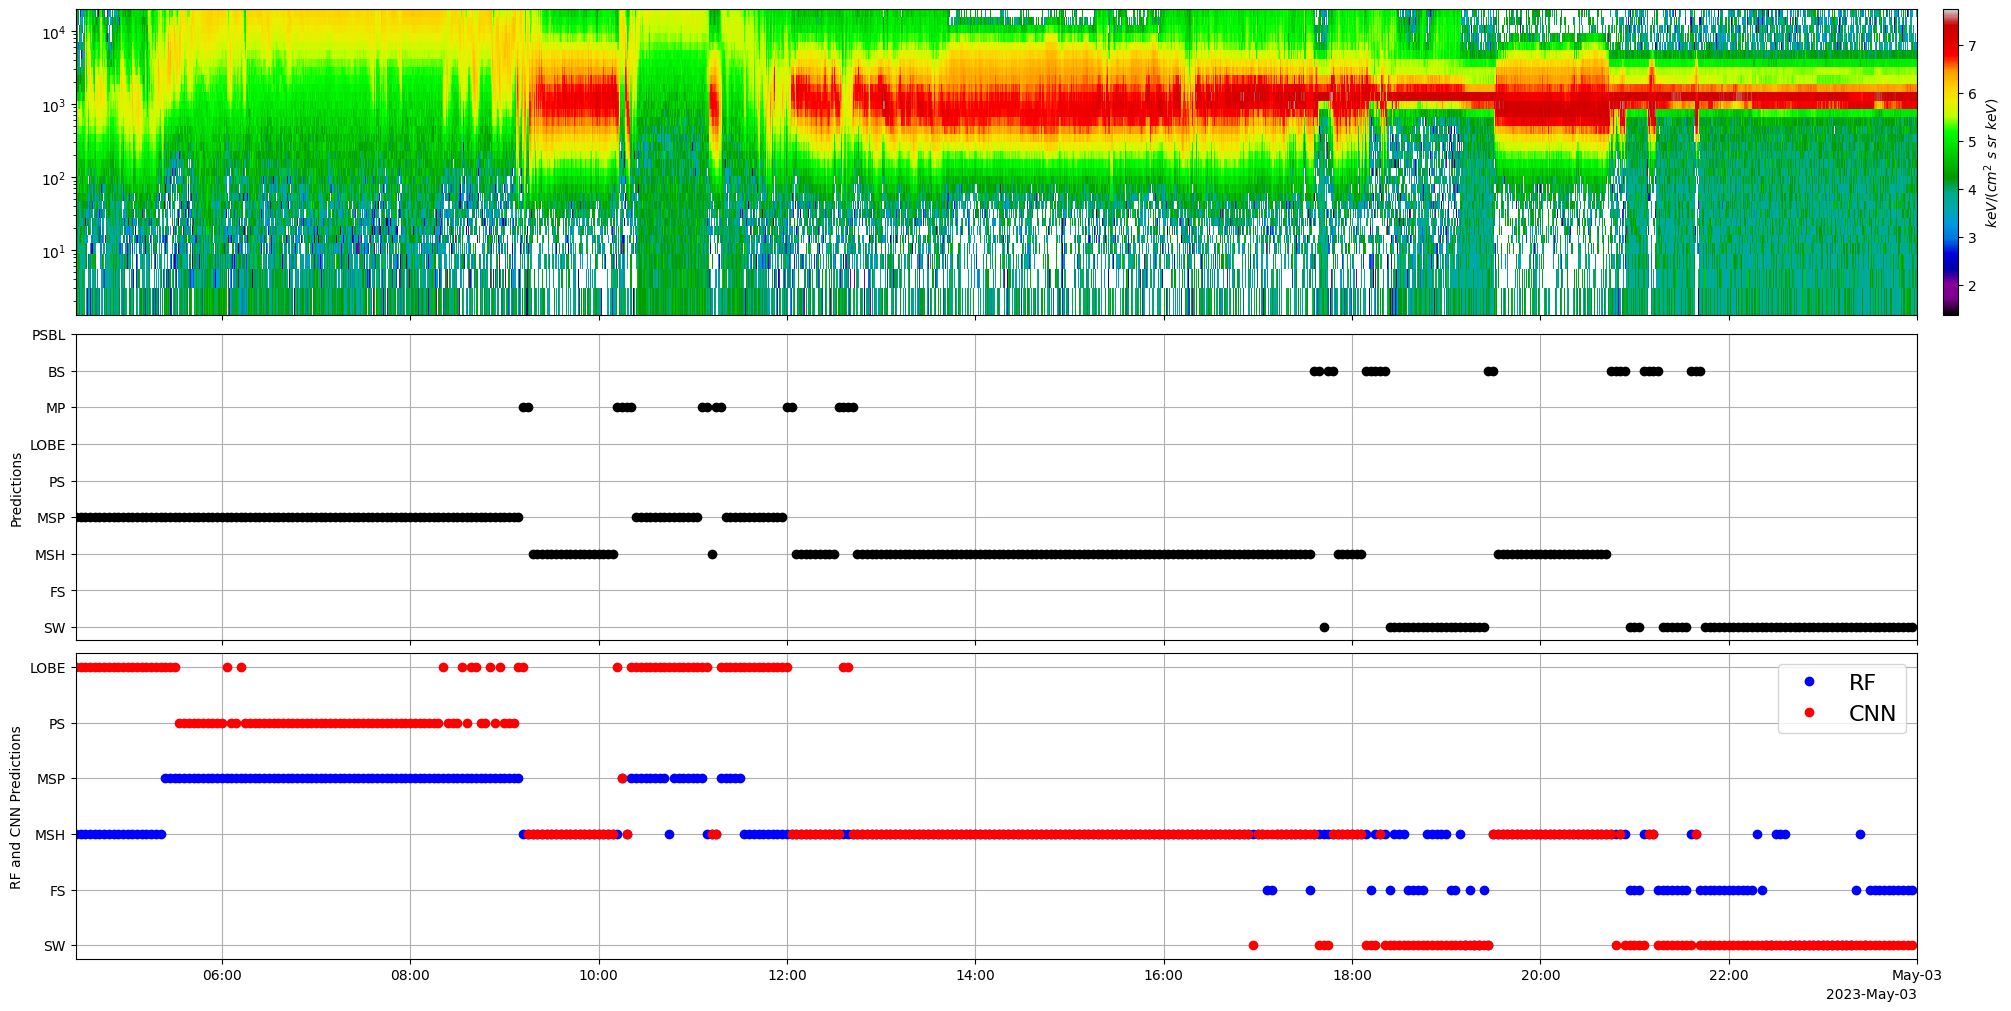

In [11]:
predictions_cnn_rf(cnn_model=cnn_model, rf_model=rf_model, trange=trange)